# Random Forest (Floresta Aleatória)

## O que é?
O Random Forest é um algoritmo de **Ensemble Learning** (Aprendizado em Conjunto) que cria uma "floresta" de várias Árvores de Decisão durante o treinamento.

### Principais Diferenciais (Baseado no Material de Apoio):
1.  **Bagging (Bootstrap Aggregating):** Cada árvore é treinada com uma amostra aleatória dos dados (com reposição), o que reduz a variância do modelo e evita o overfitting (o grande problema de uma única árvore).
2.  **Seleção Aleatória de Features:** Em cada divisão de nó, o algoritmo considera apenas um subconjunto aleatório de colunas, garantindo que as árvores sejam diferentes umas das outras (decorrelação).
3.  **Votação:** Para classificar, o modelo pega a "votação" de todas as árvores e escolhe a classe vencedora (Moda).

## Objetivo do Experimento
Utilizar o Random Forest para superar os resultados obtidos com a Decision Tree simples na detecção de **Risco de Cancelamento**, visando melhorar o equilíbrio entre Precisão e Recall.

Dados processados. Distribuição das classes:
Is_Cancelled
0    0.978111
1    0.021889
Name: proportion, dtype: float64
Treino: (284780, 6)
Teste: (122049, 6)
Treinando a Floresta Aleatória...
Modelo treinado!
--- Relatório de Classificação Random Forest ---
              precision    recall  f1-score   support

Venda Normal       0.99      0.81      0.89    119377
Cancelamento       0.07      0.59      0.12      2672

    accuracy                           0.80    122049
   macro avg       0.53      0.70      0.50    122049
weighted avg       0.97      0.80      0.87    122049



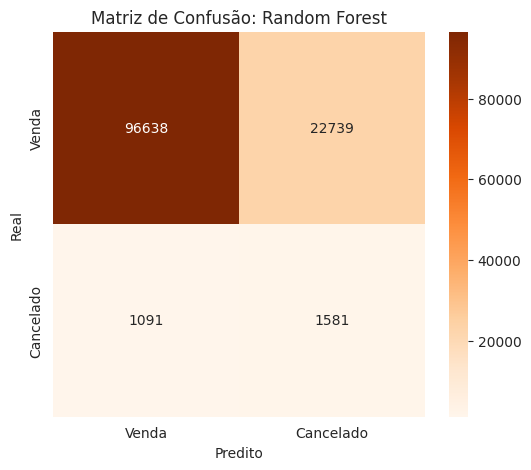

/tmp/ipykernel_93204/67909455.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Feature', data=feature_importance, palette='viridis')


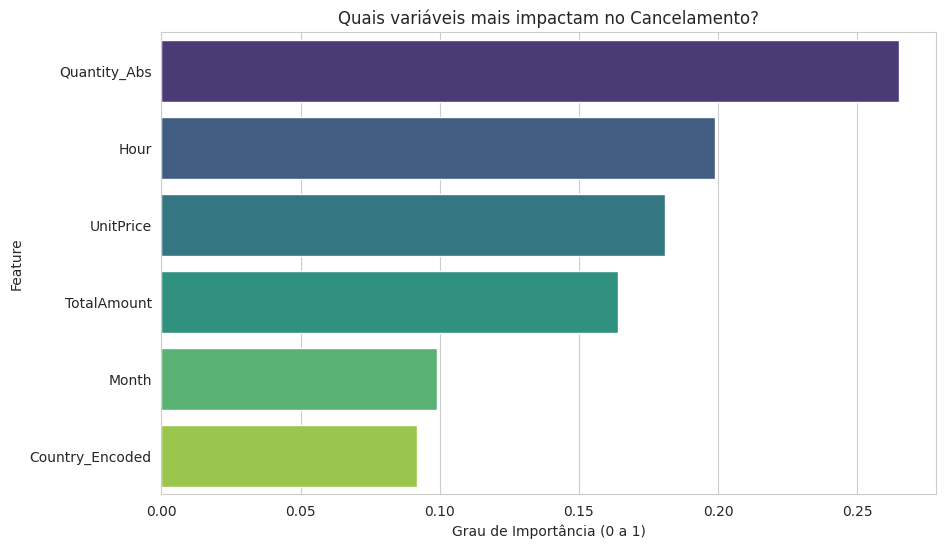

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

# Configurações visuais
sns.set_style("whitegrid")
%matplotlib inline

# 1. Carga
df = pd.read_csv('../assets/data.csv', encoding='ISO-8859-1')

# 2. Limpeza e Target
df = df.dropna(subset=['CustomerID'])
df['Is_Cancelled'] = df['InvoiceNo'].astype(str).str.upper().str.startswith('C').astype(int)

# 3. Feature Engineering
# Datas
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Hour'] = df['InvoiceDate'].dt.hour
df['Month'] = df['InvoiceDate'].dt.month

# Dados Numéricos (Evitando vazamento com abs)
df['Quantity_Abs'] = df['Quantity'].abs()
df['TotalAmount'] = df['Quantity_Abs'] * df['UnitPrice']

# Encoding de País
le = LabelEncoder()
df['Country_Encoded'] = le.fit_transform(df['Country'])

# Seleção Final
features = ['UnitPrice', 'Quantity_Abs', 'TotalAmount', 'Hour', 'Month', 'Country_Encoded']
X = df[features]
y = df['Is_Cancelled']

print("Dados processados. Distribuição das classes:")
print(y.value_counts(normalize=True))

# Divisão Treino/Teste
# Mantemos stratify=y para garantir que os cancelamentos (2%) sejam distribuídos igualmente
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape}")
print(f"Teste: {X_test.shape}")

# Instanciando o Random Forest
# n_estimators=100: Criaremos 100 árvores diferentes (padrão da indústria)
# class_weight='balanced': Fundamental para dar peso maior aos cancelamentos raros
# n_jobs=-1: Usa todos os processadores do PC para treinar mais rápido
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,       # Um pouco mais profundo que a árvore única, pois o ensemble controla o overfitting
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Treinamento
print("Treinando a Floresta Aleatória...")
rf_model.fit(X_train, y_train)
print("Modelo treinado!")


# Predições
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1] # Probabilidade para Curva ROC

# Métricas
print("--- Relatório de Classificação Random Forest ---")
print(classification_report(y_test, y_pred, target_names=['Venda Normal', 'Cancelamento']))

# Matriz de Confusão
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Venda', 'Cancelado'], yticklabels=['Venda', 'Cancelado'])
plt.title('Matriz de Confusão: Random Forest')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()


# Extraindo a importância
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importancia': rf_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Visualizando
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=feature_importance, palette='viridis')
plt.title('Quais variáveis mais impactam no Cancelamento?')
plt.xlabel('Grau de Importância (0 a 1)')
plt.show()

## 7. Análise e Interpretação dos Resultados (Conclusão)

Os resultados do **Random Forest** revelam uma estratégia de classificação agressiva, oposta à passividade observada no KNN e similar (porém mais estável) à Árvore de Decisão simples.

### Interpretação das Métricas

* **Acurácia Global (80%):** Diferente do KNN que teve 98% de acurácia prevendo apenas a classe majoritária, o Random Forest caiu para 80%. Isso não é um erro, mas uma **escolha deliberada do algoritmo**. Ao usar `class_weight='balanced'`, o modelo sacrificou a acurácia global (errando mais nas Vendas Normais) para tentar capturar os Cancelamentos. Ele está disposto a errar 20% das vendas boas para não perder os riscos.

* **Recall de Cancelamento (0.59):** O modelo detectou corretamente **59%** de todos os cancelamentos reais. Este resultado é significativamente superior aos 5% do KNN. Para um sistema de detecção de fraudes ou riscos, este é o indicador de sucesso: conseguimos "pescar" mais da metade dos problemas.

* **Precision de Cancelamento (0.07):** O custo do alto recall foi a baixa precisão. De todas as vezes que o modelo gritou "Cancelamento!", ele só acertou em 7% dos casos. Isso significa que ele gerou um volume muito alto de **Falsos Positivos**. O modelo está agindo como um "alarme sensível": dispara por qualquer suspeita.

Embora a precisão de 7% pareça baixa, em um fluxo de negócio, é mais seguro revisar manualmente transações suspeitas (mesmo que muitas sejam legítimas) do que deixar passar 95% dos cancelamentos invisíveis, como ocorreu no KNN. O modelo cumpriu o objetivo de priorizar a classe minoritária.